## Ocean memory estimates in ANHA4 NEMO simulation

Timeseries of domain-integrated ocean heat content in the North Atlantic (north of 45N) is correlated with green-function-based reconstructions from EOFs of sea level pressure data. On the basis of best correlations, ocean memory is estimated.

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import glob
import xskillscore as xs

import matplotlib.image as image
import matplotlib.patches as patches

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

/home/users/hkhatri/miniforge3/envs/xarray/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

def Moving_Avg(ds, time = 1., time_len = 12):
    
    """Compute moving averages
    Parameters
    ----------
    ds : xarray Dataset for data variables
    time : time values for computing weights
    time_len : number of grid points for moving avg
    
    Returns
    -------
    ds_avg : Dataset containting moving avg
    """
    
    if(len(time) == 1):
        
        ds_avg = ds.rolling(time = time_len, center = True).mean('time')
        
    else: 
    
        days = time.dt.daysinmonth
        
        ds_avg = ((ds * days).rolling(time = time_len, center = True).mean('time') /
                  days.rolling(time = time_len, center = True).mean('time'))
    
    return ds_avg

## Reconstructions from SLP EOF and principle component timseries

In [3]:
# Read data

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/HighResMIP/NEMO_UAlberta/Memory-ANHA4-EPM111/"

ds = xr.open_dataset(ppdir +"Recons_green_function/Response_heat_flux.nc")
ds = ds.sel(time = ds['time.year'] >= 1969) # get the same timeseries as CORE2 data
ds = ds.sel(time = ds['time.year'] <= 2009)

ds = ds.groupby('time.year').mean(dim='time') # annual-means

ds1 = xr.open_dataset(ppdir +"Recons_green_function/Response_SLP_EOF.nc")
ds1 = ds1.sel(time = ds1['time.year'] >= 1969)

days = ds1['time'].dt.days_in_month
weights = days.groupby('time.year') / days.groupby('time.year').sum(dim='time')
ds1 = (ds1 * weights).groupby('time.year').sum(dim='time')

ds = xr.merge([ds1, ds.drop(['lat', 'lon'])])

var_list = ['ao_expvar', 'ao_eofs', 'nao_expvar', 'nao_eofs']
for var in var_list:
    ds[var] = ds[var].isel(year=0)

var_list = ['votemper_subpolar_NAtl', 'votemper_arctic', 'votemper_NAtl', 'ileadfra', 'ice_vol',
            'Pred_arctic', 'Pred_subpolar_Atl', 'Pred_Atl', 'Pred_AO', 'Pred_NAO']

for var in var_list:
    ds[var] = detrend(ds[var], ['year'])

ds = ds.rename({'year':'time'})

In [4]:
ds

<xarray.Dataset> Size: 9MB
Dimensions:                 (mode: 10, lat: 94, lon: 192, time: 41, gamma: 40,
                             beta: 21)
Coordinates:
  * mode                    (mode) int64 80B 1 2 3 4 5 6 7 8 9 10
  * lat                     (lat) float64 752B -88.54 -86.65 ... 86.65 88.54
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
  * gamma                   (gamma) float64 320B 0.5 1.0 1.5 ... 19.0 19.5 20.0
  * beta                    (beta) float64 168B 0.0 0.5 1.0 1.5 ... 9.0 9.5 10.0
  * time                    (time) int64 328B 1969 1970 1971 ... 2007 2008 2009
Data variables: (12/19)
    ao_expvar               (mode) float64 80B 0.3628 0.166 ... 0.01813 0.01389
    ao_eofs                 (mode, lat, lon) float64 1MB 0.0 0.0 ... -0.001508
    ao_pcs                  (time, mode) float64 3kB 4.807e+03 ... -1.199e+03
    nao_expvar              (mode) float64 80B 0.3053 0.1684 ... 0.01998 0.01539
    nao_eofs                (mode, lat, lon) float64 1MB 0.0 0.0 0.0 ... 0.0 0.0
    nao_pcs                 (time, mode) float64 3kB 4.014e+03 ... 966.7
    ...                      ...
    sohefldo_subpolar_NAtl  (time) float64 328B 2.52e+13 ... -7.915e+13
    sohefldo_arctic         (time) float64 328B 5.36e+13 3.854e+13 ... -1.66e+12
    sohefldo_NAtl           (time) float64 328B 6.483e+13 ... -5.982e+13
    Pred_arctic             (time, gamma, beta) float64 276kB nan ... -5.54e+14
    Pred_subpolar_Atl       (time, gamma, beta) float64 276kB nan ... -5.39e+15
    Pred_Atl                (time, gamma, beta) float64 276kB nan ... -5.421e+15

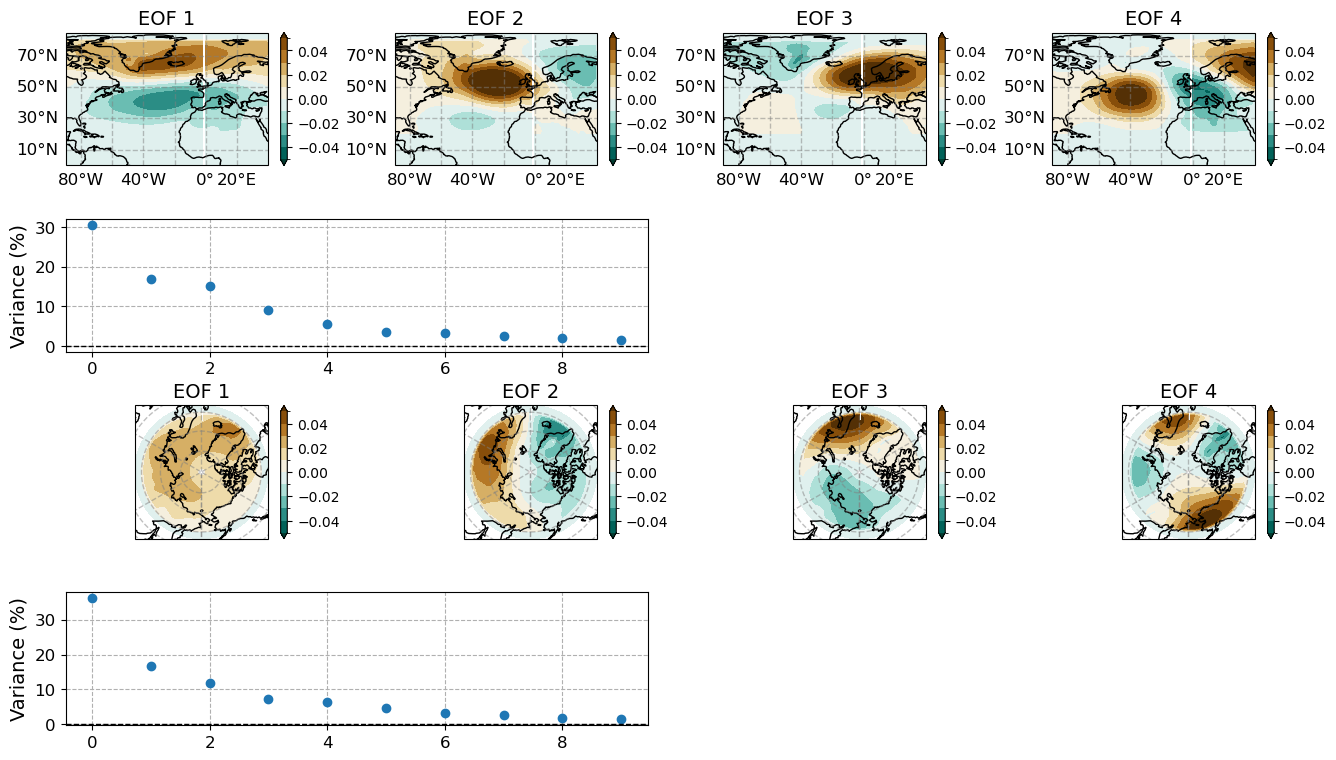

In [5]:
grid = plt.GridSpec(4, 4, wspace=0.3, hspace=0.4)
fig = plt.figure(figsize=[16,9])

# eof maps (20N-80N)
for i in range(0,4):
    ax = fig.add_subplot(grid[0, i], projection=ccrs.PlateCarree())
    tmp = ds['nao_eofs'].isel(mode=i)
    #p = tmp.plot()
    #ax.contourf(tmp['lon'], tmp['lat'], tmp)
    p = tmp.plot.contourf(ax=ax, x='lon', y='lat', vmin=-0.05, vmax=0.05, levels = 11, cmap='BrBG_r', 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=True, extend='both')
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    gl.top_labels = False
    gl.right_labels = False
    gl.ylocator = mticker.FixedLocator([70, 50, 30, 10, -10, -30, -50, -70])
    gl.xlocator = mticker.FixedLocator([-180, -160, -140, -120, -100, -80, -60, -40, 
                                        -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180])
    
    ax.coastlines()
    ax.set_xlim([-90., 40.]);
    ax.set_ylim([0., 85.]);
    ax.set_title('EOF ' + str(i+1), fontsize = 14)

ax = fig.add_subplot(grid[1, 0:2])

tmp = ds['nao_expvar']
ax.plot(tmp*100, 'o')
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.grid('on', ls='--');
ax.set_ylabel('Variance (%)', fontsize = 14)
ax.axhline(y=0, ls='--', lw=1, color='k')

# eof maps (60N-90N)
for i in range(0,4):
    ax = fig.add_subplot(grid[2, i], projection=ccrs.Orthographic(180, 90))
    tmp = ds['ao_eofs'].isel(mode=i)
    tmp = tmp.sel(lat=slice(55.,90.))
    p = tmp.plot.contourf(ax=ax, x='lon', y='lat', vmin=-0.05, vmax=0.05, levels = 11, cmap='BrBG_r', 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=True, extend='both')
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    
    ax.coastlines()
    ax.set_title('EOF ' + str(i+1), fontsize = 14)

ax = fig.add_subplot(grid[3, 0:2])

tmp = ds['ao_expvar']
ax.plot(tmp*100, 'o')
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.grid('on', ls='--');
ax.set_ylabel('Variance (%)', fontsize = 14)
ax.axhline(y=0, ls='--', lw=1, color='k')

In [62]:
ds1['nao_expvar'].isel(year=0)

<xarray.DataArray 'nao_expvar' (mode: 10)> Size: 80B
array([0.30534503, 0.16838641, 0.15049349, 0.09173324, 0.0546763 ,
       0.03475111, 0.03308235, 0.02600333, 0.01998218, 0.01538989])
Coordinates:
  * mode     (mode) int64 80B 1 2 3 4 5 6 7 8 9 10
    year     int64 8B 1969

In [63]:
ds1['ao_expvar'].isel(year=1)

<xarray.DataArray 'ao_expvar' (mode: 10)> Size: 80B
array([0.3627722 , 0.16597322, 0.11948765, 0.073326  , 0.06280691,
       0.0453581 , 0.03085579, 0.02491076, 0.01813311, 0.01388773])
Coordinates:
  * mode     (mode) int64 80B 1 2 3 4 5 6 7 8 9 10
    year     int64 8B 1970

Text(0.1, 0.95, 'Ocean Memory = 27.32$\\pm$7.11 years')

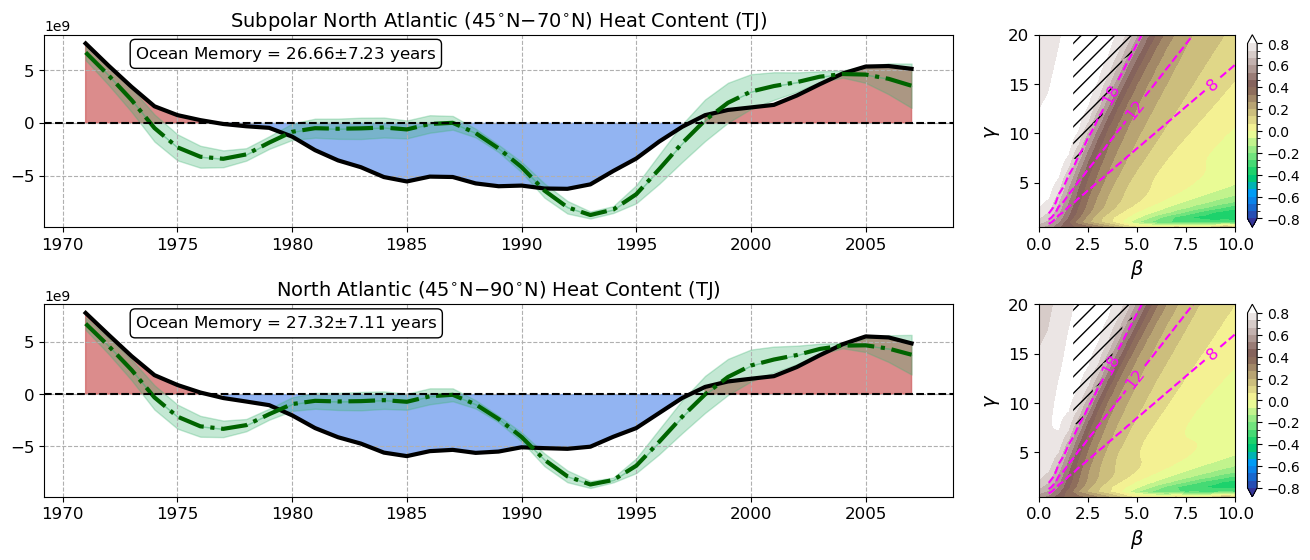

In [69]:
## reconstructions based on NAO timeseries

grid1 = plt.GridSpec(2, 4, wspace=0.35, hspace=0.4)
fig = plt.figure(figsize=[16,6])

rho_cp = 4.09*1.e6
hatch_dense = 2
fs =14

gamma_beta = ds['gamma'] * 1.5 * np.pi / ds['beta'] # all possible memory timescales

fac =  4.09*1.e6 / 1.e12 # factor to convert heat content into tera joules

### Subpolar North Atlantic heat content (45N-70N) -------------
ax = fig.add_subplot(grid1[0, 3])

corr_r = xs.pearson_r(ds['Pred_NAO'].isel(mode=0), ds['votemper_subpolar_NAtl'] * fac, 
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(ds['Pred_NAO'].isel(mode=0), ds['votemper_subpolar_NAtl'] * fac, 
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.6)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.6) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [8., 12., 18.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);


ax = fig.add_subplot(grid1[0, 0:3])
tmp = Moving_Avg(ds['votemper_subpolar_NAtl'] * fac, time = [1.], time_len = 5)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_NAO'].isel(mode=0), time = [1.], time_len = 5)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'Subpolar North Atlantic ($45^{\circ}$N$-70^{\circ}$N) Heat Content (TJ)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.95, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)


### North Atlantic (45N-90N) ------------
ax = fig.add_subplot(grid1[1, 3])

corr_r = xs.pearson_r(ds['Pred_NAO'].isel(mode=0), ds['votemper_NAtl'] * fac,
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(ds['Pred_NAO'].isel(mode=0), ds['votemper_NAtl'] * fac,
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.35)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.6) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [8., 12., 18.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);

ax = fig.add_subplot(grid1[1, 0:3])
tmp = Moving_Avg(ds['votemper_NAtl'] * fac, time = [1.], time_len = 5)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_NAO'].isel(mode=0), time = [1.], time_len = 5)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'North Atlantic ($45^{\circ}$N$-90^{\circ}$N) Heat Content (TJ)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.95, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)

Text(0.5, 0, 'EOF Mode')

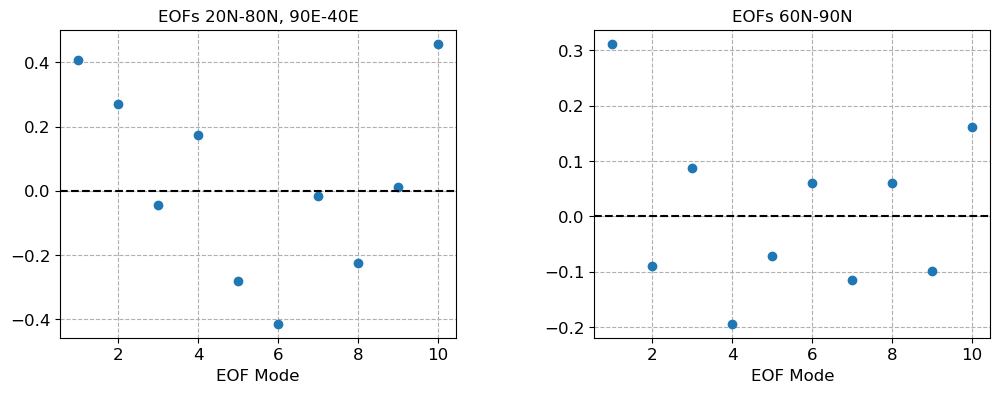

In [8]:
grid1 = plt.GridSpec(1, 2, wspace=0.35, hspace=0.4)
fig = plt.figure(figsize=[12,4])

fac =  4.09*1.e6 / 1.e12 # factor to convert heat content into tera joules
tmp = xs.pearson_r(ds['nao_pcs'], ds['votemper_subpolar_NAtl'] * fac, 
                     dim='time', skipna=True)

ax = fig.add_subplot(grid1[0, 0])
ax.plot(np.arange(len(tmp['mode'])) + 1, tmp, 'o')
ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
ax.set_title("EOFs 20N-80N, 90E-40E")
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_xlabel("EOF Mode", fontsize=12)

tmp = xs.pearson_r(ds['ao_pcs'], ds['votemper_subpolar_NAtl'] * fac, 
                     dim='time', skipna=True)

ax = fig.add_subplot(grid1[0, 1])
ax.plot(np.arange(len(tmp['mode'])) + 1, tmp, 'o')
ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
ax.set_title("EOFs 60N-90N")
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_xlabel("EOF Mode", fontsize=12)

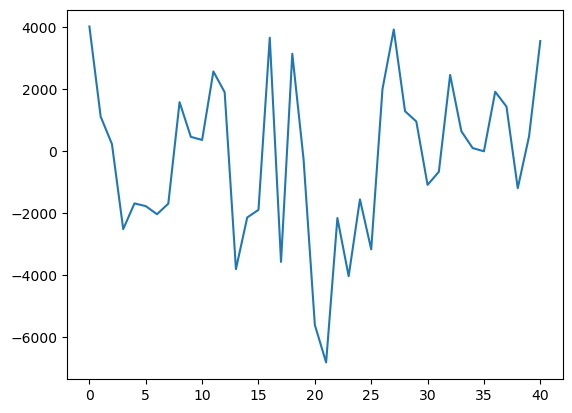

In [86]:
plt.plot(ds['nao_pcs'].isel(mode=0))

In [15]:
ds1 = xr.open_dataset(ppdir +"Recons_green_function/Response_heat_flux.nc")
tmp = xs.pearson_r(ds1['sohefldo_NAtl']/1.e15, ds1['votemper_NAtl'] * 1.e-15, 
                     dim='time', skipna=True)
tmp

<xarray.DataArray ()> Size: 4B
array(-0.11892264, dtype=float32)

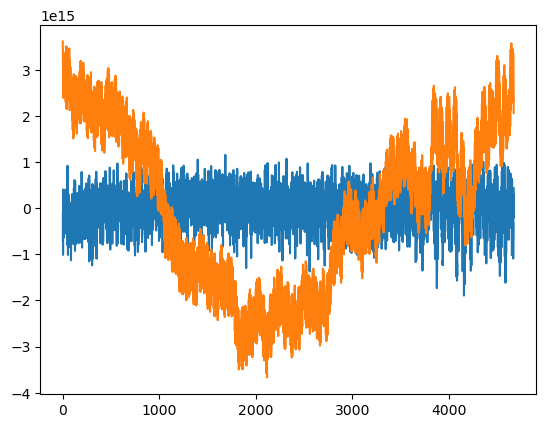

In [16]:
plt.plot(ds1['sohefldo_NAtl'])
plt.plot(ds1['votemper_NAtl'])